# Metropolis-Hastings MCMC: A Comprehensive Tutorial

The Metropolis-Hastings algorithm is a powerful Markov Chain Monte Carlo (MCMC) method for sampling from complex probability distributions. Unlike specialized methods like Gibbs sampling, Metropolis-Hastings is extremely general - you only need to evaluate the target density up to a proportionality constant.

## Algorithm Overview

Given a target distribution $\pi(x)$ that we want to sample from, Metropolis-Hastings works by:

1. **Proposal**: From current state $x_t$, propose a new state $x'$ using proposal distribution $q(x'|x_t)$
2. **Accept/Reject**: Accept $x'$ with probability $\alpha = \min\left(1, \frac{\pi(x') \times q(x_t|x')}{\pi(x_t) \times q(x'|x_t)}\right)$
3. **Update**: Set $x_{t+1} = x'$ if accepted, otherwise $x_{t+1} = x_t$

For **Random Walk Metropolis** (our focus), the proposal is symmetric: $x' = x_t + \varepsilon$ where $\varepsilon \sim \mathcal{N}(0, \sigma^2I)$. This simplifies the acceptance probability to $\alpha = \min\left(1, \frac{\pi(x')}{\pi(x_t)}\right)$.

This notebook demonstrates the algorithm with clear examples, explores the trade-offs in proposal tuning, and shows how to use ArviZ for comprehensive MCMC diagnostics.

In [ ]:
import sys
import warnings

import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats

from mc_lab.metropolis_hastings import MetropolisHastingsSampler

# Configuration
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

warnings.filterwarnings("ignore")
az.style.use("arviz-darkgrid")

# Plotting configuration
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 11

print(f"Python: {sys.version.split()[0]}")
print(f"NumPy: {np.__version__}")
print(f"ArviZ: {az.__version__}")
print(f"Random seed: {RANDOM_SEED}")

Python: 3.12.11
NumPy: 2.2.6
ArviZ: 0.22.0
Random seed: 42


## Example 1: Sampling from a 1D Normal Distribution

Let's start with the simplest case - sampling from a standard normal distribution N(0,1). This helps us understand the basic mechanics without distractions.

In [7]:
def log_standard_normal(x: float) -> float:
    """Log probability density of standard normal N(0,1)."""
    return -0.5 * x**2 - 0.5 * np.log(2 * np.pi)


# Create sampler with moderate proposal scale
sampler = MetropolisHastingsSampler(
    log_target=log_standard_normal,
    proposal_scale=1.0,
    adaptive_scaling=True,
    var_names=["x"],
)

# Generate samples
print("Sampling from standard normal distribution...")
idata = sampler.sample(
    n_samples=10000,
    n_chains=4,
    burn_in=1000,
    thin=10,
    random_seed=RANDOM_SEED,
    progressbar=True,
)

print("\nSampling complete!")
print(f"Posterior shape: {idata.posterior.x.shape} (chains × samples)")

# Check acceptance rates
acceptance_rates = sampler.get_acceptance_rates(idata)
print("\nAcceptance rates:")
for chain, rate in acceptance_rates.items():
    print(f"  {chain}: {rate:.3f}")

Sampling from standard normal distribution...


Chain 4: 100%|██████████| 101000/101000 [00:08<00:00, 11875.02it/s, accept_rate=0.309, samples=1e+4]



Sampling complete!
Posterior shape: (4, 10000) (chains × samples)

Acceptance rates:
  chain_0: 0.368
  chain_1: 0.397
  chain_2: 0.309
  chain_3: 0.309
  overall: 0.346


In [8]:
# Statistical validation
samples = idata.posterior.x.values.flatten()
sample_mean = np.mean(samples)
sample_std = np.std(samples, ddof=1)

print("Sample statistics:")
print(f"  Mean: {sample_mean:.4f} (true: 0.0000)")
print(f"  Std:  {sample_std:.4f} (true: 1.0000)")
print(f"  Min:  {np.min(samples):.4f}")
print(f"  Max:  {np.max(samples):.4f}")

# Kolmogorov-Smirnov test against true distribution
ks_stat, p_value = stats.kstest(samples, stats.norm.cdf)
print(f"\nKS test vs N(0,1): statistic={ks_stat:.4f}, p-value={p_value:.4f}")
if p_value > 0.05:
    print("✓ Samples are consistent with target distribution")
else:
    print("⚠ Samples may not match target distribution well")

Sample statistics:
  Mean: -0.0012 (true: 0.0000)
  Std:  1.0050 (true: 1.0000)
  Min:  -4.1432
  Max:  4.1031

KS test vs N(0,1): statistic=0.0025, p-value=0.9581
✓ Samples are consistent with target distribution


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

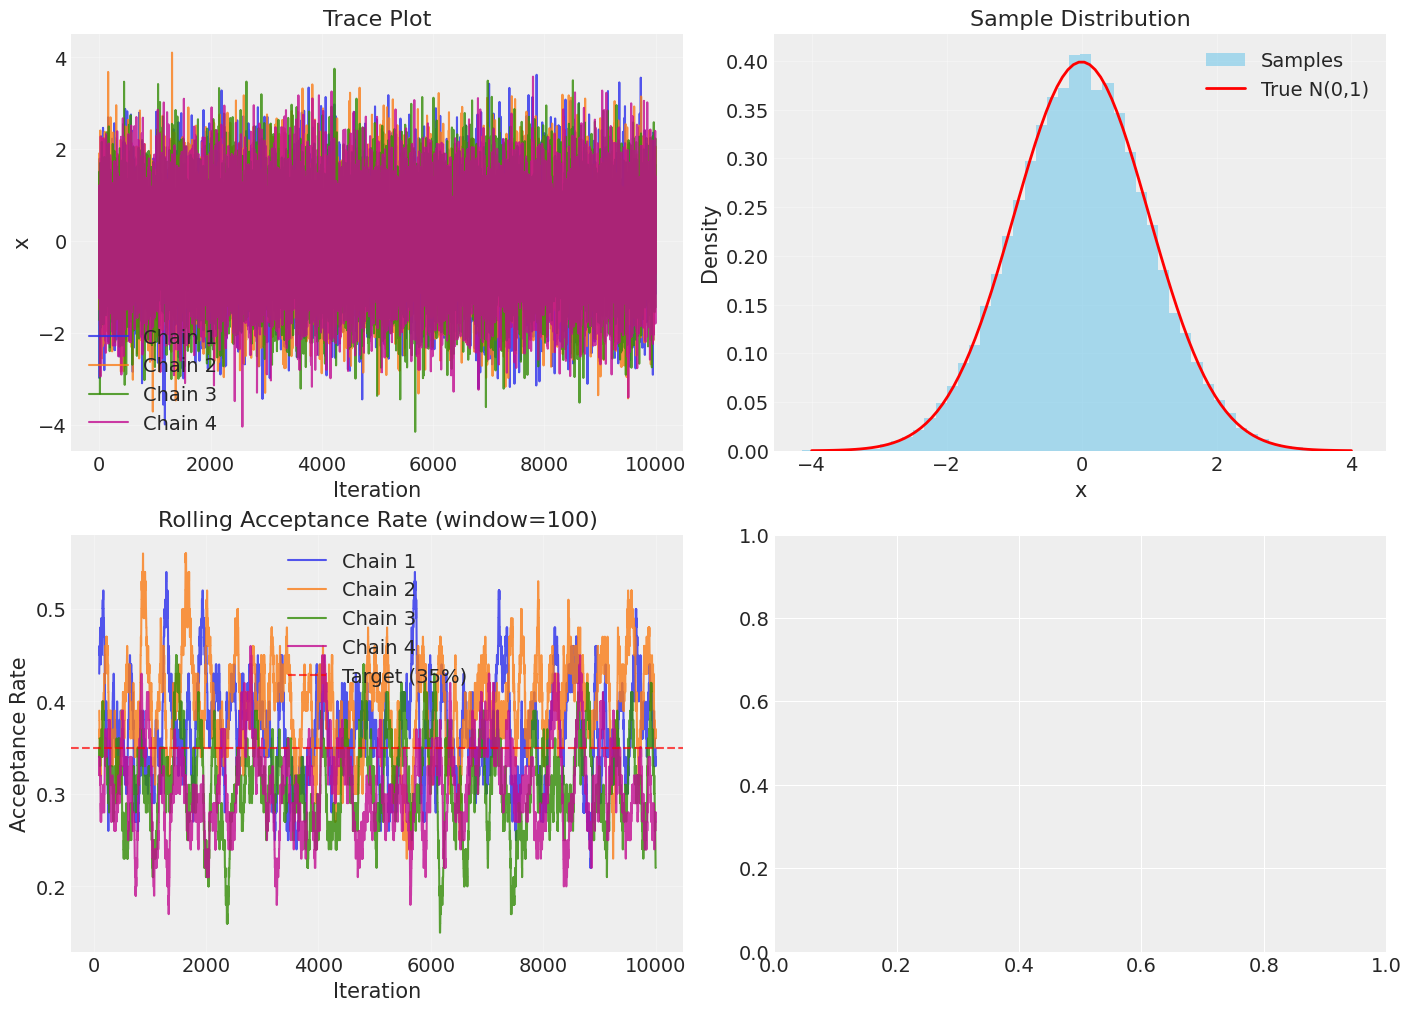

In [9]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Trace plot
ax = axes[0, 0]
for chain in range(idata.posterior.x.shape[0]):
    ax.plot(idata.posterior.x[chain], alpha=0.8, label=f"Chain {chain + 1}")
ax.set_xlabel("Iteration")
ax.set_ylabel("x")
ax.set_title("Trace Plot")
ax.legend()
ax.grid(True, alpha=0.3)

# Sample histogram vs true density
ax = axes[0, 1]
ax.hist(samples, bins=50, density=True, alpha=0.7, label="Samples", color="skyblue")
x_true = np.linspace(-4, 4, 100)
y_true = stats.norm.pdf(x_true)
ax.plot(x_true, y_true, "r-", linewidth=2, label="True N(0,1)")
ax.set_xlabel("x")
ax.set_ylabel("Density")
ax.set_title("Sample Distribution")
ax.legend()
ax.grid(True, alpha=0.3)

# Acceptance rate over time
ax = axes[1, 0]
accepted = idata.sample_stats.accepted.values
window = 100
for chain in range(accepted.shape[0]):
    # Rolling acceptance rate
    rolling_accept = np.convolve(
        accepted[chain].astype(float), np.ones(window) / window, mode="valid"
    )
    ax.plot(
        range(window - 1, len(accepted[chain])),
        rolling_accept,
        alpha=0.8,
        label=f"Chain {chain + 1}",
    )
ax.axhline(y=0.35, color="red", linestyle="--", alpha=0.7, label="Target (35%)")
ax.set_xlabel("Iteration")
ax.set_ylabel("Acceptance Rate")
ax.set_title(f"Rolling Acceptance Rate (window={window})")
ax.legend()
ax.grid(True, alpha=0.3)

# Proposal scale adaptation
ax = axes[1, 1]
proposal_scales = idata.sample_stats.proposal_scale.values
for chain in range(proposal_scales.shape[0]):
    ax.plot(proposal_scales[chain, :, 0], alpha=0.8, label=f"Chain {chain + 1}")
ax.set_xlabel("Iteration")
ax.set_ylabel("Proposal Scale")
ax.set_title("Proposal Scale Adaptation")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## ArviZ MCMC Diagnostics

ArviZ provides a comprehensive suite of MCMC diagnostics. Let's explore the most important ones for assessing chain convergence and sample quality.

In [ ]:
# Comprehensive summary statistics
print("=== ArviZ Summary ===")
summary = az.summary(idata, round_to=4)
print(summary)

print("\n=== Key Diagnostics ===")
# R-hat (should be < 1.01 for convergence)
rhat = az.rhat(idata)
print(f"R-hat: {rhat.x.values:.4f} (< 1.01 is good)")

# Effective Sample Size
ess_bulk = az.ess(idata, method="bulk")
ess_tail = az.ess(idata, method="tail")
print(f"ESS (bulk): {ess_bulk.x.values:.0f} (> 400 recommended)")
print(f"ESS (tail): {ess_tail.x.values:.0f} (> 400 recommended)")

# Monte Carlo Standard Error
mcse_mean = az.mcse(idata, method="mean")
mcse_sd = az.mcse(idata, method="sd")
print(f"MCSE (mean): {mcse_mean.x.values:.4f}")
print(f"MCSE (sd): {mcse_sd.x.values:.4f}")

print("\n=== Interpretation ===")
if rhat.x.values < 1.01:
    print("✓ R-hat indicates good convergence")
else:
    print("⚠ R-hat suggests convergence issues - run longer chains")

if ess_bulk.x.values > 400:
    print("✓ Effective sample size is adequate for mean estimation")
else:
    print("⚠ Low effective sample size - may need more samples or better mixing")

if ess_tail.x.values > 400:
    print("✓ Effective sample size is adequate for tail quantile estimation")
else:
    print("⚠ Low tail ESS - quantile estimates may be unreliable")

In [ ]:
# ArviZ diagnostic plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Trace plot with ArviZ
az.plot_trace(idata, var_names=["x"], ax=axes[0, :], combined=False)
axes[0, 0].set_title("Trace Plot (ArviZ)")
axes[0, 1].set_title("Marginal Distribution")

# Autocorrelation
az.plot_autocorr(idata, var_names=["x"], ax=axes[1, 0], combined=False)
axes[1, 0].set_title("Autocorrelation Function")

# Rank plot
az.plot_rank(idata, var_names=["x"], ax=axes[1, 1])
axes[1, 1].set_title("Rank Plot")

plt.tight_layout()
plt.show()

# ESS evolution plot
plt.figure(figsize=(12, 4))
az.plot_ess(idata, var_names=["x"], kind="evolution")
plt.title("Effective Sample Size Evolution")
plt.show()

## Example 2: The Importance of Proposal Tuning

The choice of proposal scale σ is crucial for efficient sampling. Too small → high acceptance but poor mixing. Too large → low acceptance and wasted computation. Let's explore this trade-off.

In [ ]:
def compare_proposal_scales(target_log_pdf, scales, n_samples=1000, seed=None):
    """Compare different proposal scales for the same target distribution."""
    results = {}

    for i, scale in enumerate(scales):
        print(f"\nTesting proposal scale: {scale}")

        sampler = MetropolisHastingsSampler(
            log_target=target_log_pdf,
            proposal_scale=scale,
            adaptive_scaling=False,  # Fixed scale for fair comparison
        )

        idata = sampler.sample(
            n_samples=n_samples,
            n_chains=1,
            burn_in=200,
            random_seed=seed + i if seed else None,
            progressbar=False,
        )

        # Extract results
        samples = idata.posterior.x.values.flatten()
        acceptance_rate = sampler.get_acceptance_rates(idata)["overall"]
        ess = az.ess(idata).x.values

        results[scale] = {
            "samples": samples,
            "acceptance_rate": acceptance_rate,
            "ess": ess,
            "ess_per_sample": ess / n_samples,
            "sample_var": np.var(samples, ddof=1),
        }

        print(f"  Acceptance rate: {acceptance_rate:.3f}")
        print(f"  ESS: {ess:.0f} ({ess / n_samples:.3f} efficiency)")

    return results


# Test different proposal scales
scales_to_test = [0.1, 0.5, 1.0, 2.0, 5.0]
print("Comparing proposal scales for standard normal target...")

results = compare_proposal_scales(
    target_log_pdf=log_standard_normal,
    scales=scales_to_test,
    n_samples=2000,
    seed=RANDOM_SEED,
)

In [ ]:
# Visualize the trade-offs
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Extract data for plotting
scales = list(results.keys())
accept_rates = [results[s]["acceptance_rate"] for s in scales]
ess_values = [results[s]["ess"] for s in scales]
ess_efficiency = [results[s]["ess_per_sample"] for s in scales]

# Trade-off plot: Acceptance vs ESS
ax = axes[0, 0]
colors = plt.cm.viridis(np.linspace(0, 1, len(scales)))
scatter = ax.scatter(
    accept_rates, ess_values, c=scales, cmap="viridis", s=100, alpha=0.8
)
for i, scale in enumerate(scales):
    ax.annotate(
        f"σ={scale}",
        (accept_rates[i], ess_values[i]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
    )
ax.set_xlabel("Acceptance Rate")
ax.set_ylabel("Effective Sample Size")
ax.set_title("Acceptance Rate vs ESS Trade-off")
ax.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax, label="Proposal Scale")

# Efficiency plot
ax = axes[0, 1]
ax.plot(scales, ess_efficiency, "o-", linewidth=2, markersize=8)
ax.set_xlabel("Proposal Scale")
ax.set_ylabel("ESS / Sample (Efficiency)")
ax.set_title("Sampling Efficiency vs Proposal Scale")
ax.grid(True, alpha=0.3)
# Mark the best efficiency
best_idx = np.argmax(ess_efficiency)
ax.axvline(
    scales[best_idx],
    color="red",
    linestyle="--",
    alpha=0.7,
    label=f"Best: σ={scales[best_idx]}",
)
ax.legend()

# Acceptance rate plot
ax = axes[0, 2]
ax.plot(scales, accept_rates, "s-", linewidth=2, markersize=8, color="orange")
ax.axhline(y=0.35, color="red", linestyle="--", alpha=0.7, label="Theoretical Optimum")
ax.set_xlabel("Proposal Scale")
ax.set_ylabel("Acceptance Rate")
ax.set_title("Acceptance Rate vs Proposal Scale")
ax.grid(True, alpha=0.3)
ax.legend()

# Sample traces for extreme cases
extreme_scales = [0.1, 2.0]  # Too small, good scale
for i, scale in enumerate(extreme_scales):
    ax = axes[1, i]
    trace = results[scale]["samples"][:500]  # First 500 samples
    ax.plot(trace, alpha=0.8)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("x")
    ax.set_title(f"Trace: σ={scale} (Accept: {results[scale]['acceptance_rate']:.3f})")
    ax.grid(True, alpha=0.3)

    # Add interpretation
    if scale == 0.1:
        ax.text(
            0.05,
            0.95,
            "Too small: High acceptance\nbut poor mixing",
            transform=ax.transAxes,
            va="top",
            bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.7),
        )
    else:
        ax.text(
            0.05,
            0.95,
            "Good scale: Balanced\nacceptance and mixing",
            transform=ax.transAxes,
            va="top",
            bbox=dict(boxstyle="round", facecolor="lightgreen", alpha=0.7),
        )

# Summary table
ax = axes[1, 2]
ax.axis("tight")
ax.axis("off")

table_data = []
for scale in scales:
    r = results[scale]
    table_data.append(
        [
            f"{scale}",
            f"{r['acceptance_rate']:.3f}",
            f"{r['ess']:.0f}",
            f"{r['ess_per_sample']:.3f}",
        ]
    )

table = ax.table(
    cellText=table_data,
    colLabels=["Scale σ", "Accept Rate", "ESS", "Efficiency"],
    cellLoc="center",
    loc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
ax.set_title("Summary Statistics", pad=20)

plt.tight_layout()
plt.show()

print("\n=== Key Insights ===")
print(
    f"Best efficiency at σ={scales[best_idx]} with {ess_efficiency[best_idx]:.3f} ESS/sample"
)
print("Theoretical optimal acceptance rate: ~0.35 for 1D problems")
print(
    f"Closest to optimal: σ={scales[np.argmin(np.abs(np.array(accept_rates) - 0.35))]}"
)

## Example 3: 2D Multivariate Normal Distribution

Let's move to a more complex example - a 2D correlated normal distribution. This shows how the sampler handles multivariate targets and correlation structures.

In [ ]:
# Define a 2D correlated normal distribution
true_mean = np.array([2.0, -1.0])
true_cov = np.array([[1.5, 0.8], [0.8, 2.0]])
cov_inv = np.linalg.inv(true_cov)
log_det_cov = np.log(np.linalg.det(true_cov))


def log_mvn_2d(x):
    """Log PDF of 2D multivariate normal distribution."""
    x = np.atleast_1d(x)
    diff = x - true_mean
    return -0.5 * (diff @ cov_inv @ diff + log_det_cov + 2 * np.log(2 * np.pi))


print("2D Multivariate Normal Distribution:")
print(f"Mean: {true_mean}")
print("Covariance:")
print(true_cov)
print(f"Correlation: {true_cov[0, 1] / np.sqrt(true_cov[0, 0] * true_cov[1, 1]):.3f}")

# Create sampler with dimension-specific proposal scales
sampler_2d = MetropolisHastingsSampler(
    log_target=log_mvn_2d,
    proposal_scale=np.array([0.8, 0.9]),  # Different scales for each dimension
    var_names=["theta1", "theta2"],
    adaptive_scaling=True,
)

# Generate samples
print("\nSampling from 2D multivariate normal...")
idata_2d = sampler_2d.sample(
    n_samples=3000,
    n_chains=4,
    burn_in=1000,
    thin=1,
    random_seed=RANDOM_SEED,
    progressbar=True,
)

print("\nSampling complete!")
print(f"Shape - theta1: {idata_2d.posterior.theta1.shape}")
print(f"Shape - theta2: {idata_2d.posterior.theta2.shape}")

In [ ]:
# Extract and analyze samples
samples_theta1 = idata_2d.posterior.theta1.values.flatten()
samples_theta2 = idata_2d.posterior.theta2.values.flatten()
samples_2d = np.column_stack([samples_theta1, samples_theta2])

# Compute sample statistics
sample_mean_2d = np.mean(samples_2d, axis=0)
sample_cov_2d = np.cov(samples_2d.T)
sample_corr = sample_cov_2d[0, 1] / np.sqrt(sample_cov_2d[0, 0] * sample_cov_2d[1, 1])
true_corr = true_cov[0, 1] / np.sqrt(true_cov[0, 0] * true_cov[1, 1])

print("=== 2D Multivariate Normal Results ===")
print("\nMeans:")
print(f"  Sample: [{sample_mean_2d[0]:.3f}, {sample_mean_2d[1]:.3f}]")
print(f"  True:   [{true_mean[0]:.3f}, {true_mean[1]:.3f}]")
print(
    f"  Error:  [{abs(sample_mean_2d[0] - true_mean[0]):.3f}, {abs(sample_mean_2d[1] - true_mean[1]):.3f}]"
)

print("\nCovariances:")
print("Sample:")
print(f"  [{sample_cov_2d[0, 0]:.3f}, {sample_cov_2d[0, 1]:.3f}]")
print(f"  [{sample_cov_2d[1, 0]:.3f}, {sample_cov_2d[1, 1]:.3f}]")
print("True:")
print(f"  [{true_cov[0, 0]:.3f}, {true_cov[0, 1]:.3f}]")
print(f"  [{true_cov[1, 0]:.3f}, {true_cov[1, 1]:.3f}]")

print("\nCorrelation:")
print(f"  Sample: {sample_corr:.4f}")
print(f"  True:   {true_corr:.4f}")
print(f"  Error:  {abs(sample_corr - true_corr):.4f}")

# Acceptance rates by chain
acceptance_rates_2d = sampler_2d.get_acceptance_rates(idata_2d)
print("\nAcceptance rates:")
for chain, rate in acceptance_rates_2d.items():
    print(f"  {chain}: {rate:.3f}")

# ArviZ summary
print("\n=== ArviZ Diagnostics ===")
rhat_2d = az.rhat(idata_2d)
ess_2d = az.ess(idata_2d)
print(
    f"R-hat - theta1: {rhat_2d.theta1.values:.4f}, theta2: {rhat_2d.theta2.values:.4f}"
)
print(f"ESS   - theta1: {ess_2d.theta1.values:.0f}, theta2: {ess_2d.theta2.values:.0f}")

In [ ]:
# Comprehensive 2D visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Joint scatter plot with true distribution contours
ax_main = fig.add_subplot(gs[:2, :2])

# Sample scatter plot
ax_main.scatter(
    samples_theta1, samples_theta2, alpha=0.3, s=1, c="blue", label="Samples"
)

# True distribution contours
x_range = np.linspace(samples_theta1.min() - 0.5, samples_theta1.max() + 0.5, 100)
y_range = np.linspace(samples_theta2.min() - 0.5, samples_theta2.max() + 0.5, 100)
X, Y = np.meshgrid(x_range, y_range)
pos = np.dstack((X, Y))

# True density for contours
true_density = stats.multivariate_normal(true_mean, true_cov)
ax_main.contour(X, Y, true_density.pdf(pos), levels=5, colors="red", alpha=0.8)
ax_main.contour(
    X,
    Y,
    true_density.pdf(pos),
    levels=[0.05],
    colors="red",
    linewidths=2,
    linestyles="--",
    alpha=0.8,
)

# Mark true and sample means
ax_main.scatter(
    *true_mean, color="red", s=100, marker="x", linewidth=3, label="True Mean"
)
ax_main.scatter(
    *sample_mean_2d, color="orange", s=100, marker="+", linewidth=3, label="Sample Mean"
)

ax_main.set_xlabel("theta1")
ax_main.set_ylabel("theta2")
ax_main.set_title("2D Sample Distribution with True Contours")
ax_main.legend()
ax_main.grid(True, alpha=0.3)

# Marginal histogram - theta1
ax_marg_x = fig.add_subplot(gs[2, :2])
ax_marg_x.hist(
    samples_theta1, bins=50, density=True, alpha=0.7, color="blue", label="Samples"
)
# True marginal
x_true = np.linspace(samples_theta1.min(), samples_theta1.max(), 100)
true_marg_1 = stats.norm.pdf(x_true, true_mean[0], np.sqrt(true_cov[0, 0]))
ax_marg_x.plot(x_true, true_marg_1, "r-", linewidth=2, label="True Marginal")
ax_marg_x.set_xlabel("theta1")
ax_marg_x.set_ylabel("Density")
ax_marg_x.set_title("theta1 Marginal Distribution")
ax_marg_x.legend()
ax_marg_x.grid(True, alpha=0.3)

# Marginal histogram - theta2
ax_marg_y = fig.add_subplot(gs[:2, 2])
ax_marg_y.hist(
    samples_theta2,
    bins=50,
    density=True,
    alpha=0.7,
    color="blue",
    orientation="horizontal",
)
# True marginal
y_true = np.linspace(samples_theta2.min(), samples_theta2.max(), 100)
true_marg_2 = stats.norm.pdf(y_true, true_mean[1], np.sqrt(true_cov[1, 1]))
ax_marg_y.plot(true_marg_2, y_true, "r-", linewidth=2)
ax_marg_y.set_ylabel("theta2")
ax_marg_y.set_xlabel("Density")
ax_marg_y.set_title("theta2 Marginal Distribution")
ax_marg_y.grid(True, alpha=0.3)

plt.show()

# ArviZ-specific plots
print("\n=== ArviZ Diagnostic Plots ===")

# Trace plot
az.plot_trace(idata_2d, figsize=(14, 6))
plt.suptitle("2D MCMC Trace Plots", y=1.02)
plt.show()

# Pair plot
az.plot_pair(idata_2d, figsize=(10, 8), kind=["scatter", "kde"], marginals=True)
plt.suptitle("Pair Plot with Marginals", y=1.02)
plt.show()

# Posterior distributions
az.plot_posterior(
    idata_2d, figsize=(12, 4), ref_val={"theta1": true_mean[0], "theta2": true_mean[1]}
)
plt.suptitle("Posterior Distributions with True Values", y=1.02)
plt.show()

## Example 4: Challenging Distribution - Banana-Shaped

Let's test the sampler on a more challenging target: a "banana-shaped" distribution. This tests the algorithm's ability to handle strong correlations and nonlinear relationships.

In [ ]:
def log_banana_distribution(x, a=1.0, b=100.0):
    """
    Log density of the famous 'banana' distribution.

    This is a transformed 2D normal where:
    - x1 ~ N(0, a²)
    - x2 | x1 ~ N(b*x1², 1)

    The result is a curved, banana-shaped distribution that's
    challenging for MCMC due to strong nonlinear correlation.
    """
    x = np.atleast_1d(x)
    if len(x) != 2:
        raise ValueError("Banana distribution requires 2D input")

    x1, x2 = x[0], x[1]

    # Log density components
    log_p_x1 = -0.5 * (x1**2) / (a**2) - 0.5 * np.log(2 * np.pi * a**2)
    log_p_x2_given_x1 = -0.5 * (x2 - b * x1**2) ** 2 - 0.5 * np.log(2 * np.pi)

    return log_p_x1 + log_p_x2_given_x1


# Create banana sampler
print("Setting up banana distribution sampler...")
print("This is a challenging nonlinear target with strong correlation.")

sampler_banana = MetropolisHastingsSampler(
    log_target=lambda x: log_banana_distribution(x, a=2.0, b=0.5),
    proposal_scale=np.array([0.5, 0.8]),  # May need tuning
    var_names=["x1", "x2"],
    adaptive_scaling=True,
    target_acceptance_rate=0.3,  # Slightly lower for challenging target
)

# Generate samples (need more for challenging distribution)
print("\nSampling from banana distribution...")
print("This may take longer due to the challenging geometry.")

idata_banana = sampler_banana.sample(
    n_samples=4000,
    n_chains=4,
    burn_in=2000,  # Longer burn-in for challenging target
    thin=2,  # More thinning to reduce correlation
    initial_states=np.array([[-1, 0], [1, 0], [0, -2], [0, 2]]),  # Overdispersed starts
    random_seed=RANDOM_SEED,
    progressbar=True,
)

print("\nBanana sampling complete!")

In [ ]:
# Analyze banana distribution results
samples_x1 = idata_banana.posterior.x1.values.flatten()
samples_x2 = idata_banana.posterior.x2.values.flatten()
samples_banana = np.column_stack([samples_x1, samples_x2])

print("=== Banana Distribution Results ===")
print(f"Total samples: {len(samples_x1)}")
print(f"Sample means: x1={np.mean(samples_x1):.3f}, x2={np.mean(samples_x2):.3f}")
print(f"Sample stds:  x1={np.std(samples_x1):.3f}, x2={np.std(samples_x2):.3f}")

# Acceptance rates
banana_acceptance = sampler_banana.get_acceptance_rates(idata_banana)
print("\nAcceptance rates:")
for chain, rate in banana_acceptance.items():
    print(f"  {chain}: {rate:.3f}")

# Convergence diagnostics
rhat_banana = az.rhat(idata_banana)
ess_banana = az.ess(idata_banana)

print("\n=== Convergence Diagnostics ===")
print(f"R-hat - x1: {rhat_banana.x1.values:.4f}, x2: {rhat_banana.x2.values:.4f}")
print(f"ESS   - x1: {ess_banana.x1.values:.0f}, x2: {ess_banana.x2.values:.0f}")

# Check for convergence issues
convergence_ok = True
if rhat_banana.x1.values > 1.01 or rhat_banana.x2.values > 1.01:
    print("⚠ R-hat indicates potential convergence issues")
    convergence_ok = False

if ess_banana.x1.values < 400 or ess_banana.x2.values < 400:
    print("⚠ Low effective sample size - consider longer runs")
    convergence_ok = False

if convergence_ok:
    print("✓ Convergence diagnostics look good!")
else:
    print("  This is expected for challenging distributions.")
    print("  In practice, you might need longer chains or better proposals.")

In [ ]:
# Visualize the banana distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Main scatter plot
ax = axes[0, 0]
colors = plt.cm.tab10(np.arange(4))
for chain in range(4):
    chain_x1 = idata_banana.posterior.x1.values[chain]
    chain_x2 = idata_banana.posterior.x2.values[chain]
    ax.scatter(
        chain_x1,
        chain_x2,
        alpha=0.5,
        s=2,
        color=colors[chain],
        label=f"Chain {chain + 1}",
    )

ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Banana Distribution Samples (Colored by Chain)")
ax.legend()
ax.grid(True, alpha=0.3)

# Density contours
ax = axes[0, 1]
ax.scatter(samples_x1, samples_x2, alpha=0.3, s=1, c="blue")

# Generate true banana contours
x1_range = np.linspace(samples_x1.min() - 0.5, samples_x1.max() + 0.5, 50)
x2_range = np.linspace(samples_x2.min() - 1, samples_x2.max() + 1, 50)
X1_grid, X2_grid = np.meshgrid(x1_range, x2_range)

# Compute log densities on grid
log_densities = np.zeros_like(X1_grid)
for i in range(X1_grid.shape[0]):
    for j in range(X1_grid.shape[1]):
        log_densities[i, j] = log_banana_distribution(
            [X1_grid[i, j], X2_grid[i, j]], a=2.0, b=0.5
        )

densities = np.exp(log_densities)
ax.contour(X1_grid, X2_grid, densities, levels=8, colors="red", alpha=0.8)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Banana Shape with True Contours")
ax.grid(True, alpha=0.3)

# Trace plots
ax = axes[0, 2]
for chain in range(4):
    ax.plot(
        idata_banana.posterior.x1.values[chain][:500],
        alpha=0.7,
        color=colors[chain],
        label=f"Chain {chain + 1}" if chain == 0 else "",
    )
ax.set_xlabel("Iteration")
ax.set_ylabel("x1")
ax.set_title("x1 Trace Plot (First 500 samples)")
ax.grid(True, alpha=0.3)

# x2 trace
ax = axes[1, 0]
for chain in range(4):
    ax.plot(
        idata_banana.posterior.x2.values[chain][:500], alpha=0.7, color=colors[chain]
    )
ax.set_xlabel("Iteration")
ax.set_ylabel("x2")
ax.set_title("x2 Trace Plot (First 500 samples)")
ax.grid(True, alpha=0.3)

# Marginal distributions
ax = axes[1, 1]
ax.hist(samples_x1, bins=50, density=True, alpha=0.7, color="blue", label="x1 samples")
ax.set_xlabel("x1")
ax.set_ylabel("Density")
ax.set_title("x1 Marginal Distribution")
ax.grid(True, alpha=0.3)

ax = axes[1, 2]
ax.hist(
    samples_x2, bins=50, density=True, alpha=0.7, color="orange", label="x2 samples"
)
ax.set_xlabel("x2")
ax.set_ylabel("Density")
ax.set_title("x2 Marginal Distribution")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ArviZ diagnostic plots for banana
print("\n=== ArviZ Diagnostics for Banana Distribution ===")

# Trace plot
az.plot_trace(idata_banana, figsize=(14, 6))
plt.suptitle("Banana Distribution - Trace Plots", y=1.02)
plt.show()

# Autocorrelation
az.plot_autocorr(idata_banana, figsize=(12, 4), combined=False, max_lag=100)
plt.suptitle("Autocorrelation Functions", y=1.02)
plt.show()

print("\n=== Key Observations ===")
print("• The banana shape creates strong nonlinear correlation")
print("• Trace plots may show slower mixing due to the curved geometry")
print("• Autocorrelation tends to be higher for challenging targets")
print("• Multiple chains help detect convergence issues")
print("• This demonstrates why adaptive proposal scaling is important")

## Practical Tips and Best Practices

Based on our examples, here are key guidelines for successful Metropolis-Hastings sampling:

In [ ]:
def demonstrate_best_practices():
    """Demonstrate key best practices with examples."""

    print("=" * 60)
    print("METROPOLIS-HASTINGS BEST PRACTICES")
    print("=" * 60)

    print("\n1. PROPOSAL SCALE TUNING")
    print(
        "   • Target acceptance rate: 20-50% (theory suggests ~23% for 1D, ~44% for high-D)"
    )
    print("   • Too high acceptance (>70%): Steps too small, poor mixing")
    print("   • Too low acceptance (<10%): Steps too large, wasted computation")
    print("   • Use adaptive scaling during burn-in, then fix for inference")

    print("\n2. CHAIN INITIALIZATION")
    print("   • Use multiple chains (≥4) with overdispersed starting points")
    print("   • Starting points should cover the typical set of the posterior")
    print("   • Avoid starting all chains at the same point")

    print("\n3. BURN-IN AND THINNING")
    print("   • Burn-in: Discard initial samples while chain reaches stationarity")
    print("   • Rule of thumb: 10-50% of total run for burn-in")
    print("   • Thinning: Keep every k-th sample to reduce autocorrelation")
    print("   • Better to run longer than to thin heavily")

    print("\n4. CONVERGENCE DIAGNOSTICS")
    print("   • R̂ (R-hat): < 1.01 indicates convergence across chains")
    print("   • Effective Sample Size (ESS): > 400 for reliable estimates")
    print("   • Trace plots: Should look like 'fuzzy caterpillars'")
    print("   • Autocorrelation: Should decay to near zero")

    print("\n5. WHEN TO USE METROPOLIS-HASTINGS")
    print("   ✓ General-purpose: Works with any target density")
    print("   ✓ Unknown normalizing constants: Only needs density ratios")
    print("   ✓ Complex geometries: Can handle multimodal, constrained distributions")
    print("   ⚠ May be slow for high-dimensional problems")
    print("   ⚠ Requires careful tuning for optimal performance")

    print("\n6. TROUBLESHOOTING COMMON ISSUES")
    print("   Problem: Poor mixing (trace plots show sticking)")
    print("   → Solution: Tune proposal scale, try different starting points")

    print("   Problem: High R̂ values")
    print("   → Solution: Run longer chains, check for multimodality")

    print("   Problem: Low ESS")
    print("   → Solution: Run more samples, reduce autocorrelation")

    print("   Problem: All chains stuck in one mode")
    print("   → Solution: More dispersed initialization, longer runs")


demonstrate_best_practices()

In [ ]:
# Summary comparison of our examples
print("\n" + "=" * 80)
print("SUMMARY: COMPARISON OF EXAMPLES")
print("=" * 80)

examples = {
    "1D Normal": {
        "Target": "N(0, 1)",
        "Difficulty": "Easy",
        "Acceptance": f"{sampler.get_acceptance_rates(idata)['overall']:.3f}",
        "R-hat": f"{az.rhat(idata).x.values:.4f}",
        "ESS": f"{az.ess(idata).x.values:.0f}",
        "Key Learning": "Basic algorithm, proposal tuning",
    },
    "2D MVN": {
        "Target": "Correlated 2D Normal",
        "Difficulty": "Moderate",
        "Acceptance": f"{sampler_2d.get_acceptance_rates(idata_2d)['overall']:.3f}",
        "R-hat": f"{max(az.rhat(idata_2d).theta1.values, az.rhat(idata_2d).theta2.values):.4f}",
        "ESS": f"{min(az.ess(idata_2d).theta1.values, az.ess(idata_2d).theta2.values):.0f}",
        "Key Learning": "Multivariate sampling, correlation",
    },
    "Banana": {
        "Target": "Nonlinear correlation",
        "Difficulty": "Hard",
        "Acceptance": f"{sampler_banana.get_acceptance_rates(idata_banana)['overall']:.3f}",
        "R-hat": f"{max(az.rhat(idata_banana).x1.values, az.rhat(idata_banana).x2.values):.4f}",
        "ESS": f"{min(az.ess(idata_banana).x1.values, az.ess(idata_banana).x2.values):.0f}",
        "Key Learning": "Challenging geometry, adaptation",
    },
}


df = pd.DataFrame(examples).T
print(df.to_string())

print("\n" + "=" * 80)
print("FINAL THOUGHTS")
print("=" * 80)
print(
    "Metropolis-Hastings is a powerful, general-purpose MCMC algorithm that can\n"
    "sample from virtually any continuous distribution. The key to success is:\n\n"
    "1. Proper proposal tuning (acceptance rates 20-50%)\n"
    "2. Multiple chains with good initialization\n"
    "3. Adequate burn-in and sample size\n"
    "4. Rigorous convergence diagnostics with ArviZ\n\n"
    "While it may not be the most efficient method for specific problems,\n"
    "its generality makes it an essential tool in the MCMC toolkit.\n\n"
    "For specialized cases (e.g., conjugate models), consider Gibbs sampling.\n"
    "For high-dimensional problems, explore Hamiltonian Monte Carlo (HMC).\n"
    "But when you need a reliable, general method, Metropolis-Hastings delivers!"
)

In [ ]:
# Environment and reproducibility information
print("\n" + "=" * 60)
print("REPRODUCIBILITY INFORMATION")
print("=" * 60)


print(f"Python version: {sys.version.split()[0]}")
print(f"NumPy version: {np.__version__}")
print(f"SciPy version: {stats.__version__ if hasattr(stats, '__version__') else 'N/A'}")
print(f"ArviZ version: {az.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")
print(f"Random seed used: {RANDOM_SEED}")

print("\nNotebook completed successfully!")
print("All examples demonstrate the Metropolis-Hastings algorithm with")
print("comprehensive ArviZ integration for professional MCMC workflows.")